# ABM de Contagio Bancario Multicapa para Bolivia (con “corrida a dolarización” y restricción de divisas)

## 1. Motivación y contribución (para paper/conferencia)
Este modelo es un **ABM de contagio bancario** diseñado para economías emergentes “tipo Bolivia”, donde coexisten:

- **Alta bolivianización de la cartera** (crédito mayormente en moneda nacional) y **dolarización parcial de depósitos**.
- Un **ancla cambiaria oficial** y un **límite operativo de liquidez en divisas** (reservas “líquidas” acotadas).
- **Segmentación productiva e informalidad** que altera la sensibilidad de mora ante estrés macro (inflación, depreciación, contracción del crédito).

La contribución “novedosa” es que el contagio opera por **tres capas simultáneas**:
1) **Red interbancaria (solvencia):** pérdidas por incumplimiento de obligaciones entre bancos (clearing).
2) **Liquidez y fire-sales (mercado de bonos):** ventas forzadas deprimen precios, erosionan capital y disparan más ventas.
3) **Riesgo de dolarización (mismatch FX):** hogares migran depósitos a USD o los retiran; los bancos compiten por divisas escasas, amplificando el estrés.

El modelo permite evaluar el rol **macro-estabilizador** de un **banco público** (crédito/market-maker) sujeto a restricción de capital y liquidez.

---

## 2. Agentes y estados

### 2.1 Bancos (i = 1,...,N)
Cada banco tiene balance simplificado con activos en bolivianos y una posición en divisas:

**Activos**
- $L_{i,t}$ : cartera de créditos (MN)
- $B_{i,t}$ : bonos/valores (MN) con precio de mercado $P^B_t$
- $C_{i,t}$ : caja/activos líquidos (MN)
- $IA_{i,t}$ : activos interbancarios (préstamos otorgados a otros bancos)
- $FXA_{i,t}$ : activos en divisas (USD) valorados a tipo de cambio $e_t$ (Bs/USD)

**Pasivos**
- $D^{MN}_{i,t}$ : depósitos en moneda nacional
- $D^{FX}_{i,t}$ : depósitos en divisas (USD)
- $IL_{i,t}$ : pasivos interbancarios (deudas con otros bancos)
- $O_{i,t}$ : otros pasivos (simplificado)

**Patrimonio**
- $E_{i,t} = A_{i,t} - \Lambda_{i,t}$

donde el valor contable en Bs es:
- $A_{i,t} = L_{i,t} + P^B_t B_{i,t} + C_{i,t} + IA_{i,t} + e_t FXA_{i,t}$
- $\Lambda_{i,t} = D^{MN}_{i,t} + e_t D^{FX}_{i,t} + IL_{i,t} + O_{i,t}$

**Capital regulatorio (proxy)**
- $RWA_{i,t} = w_L L_{i,t} + w_B (P^B_t B_{i,t}) + w_{IB} IA_{i,t} + w_{FX}(e_t FXA_{i,t})$
- $CAR_{i,t} = \dfrac{E_{i,t}}{RWA_{i,t}}$

---

### 2.2 Hogares depositantes (agente representativo con regla conductual)
Los hogares eligen fracción de depósitos en USD vs MN según inflación, expectativas de depreciación y estrés bancario:

- Share de dolarización:
  $s^{FX}_{t+1} = \sigma(\eta_0 + \eta_1 \Delta \ln e_t + \eta_2 \pi_t + \eta_3 Stress_t)$

donde $\sigma(x)=\dfrac{1}{1+e^{-x}}$ y $Stress_t$ es un índice agregado (ej. % de bancos con $CAR<\kappa$).

**Corrida (retiros)**
La tasa de retiro (run) para banco i aumenta cuando el banco cae por debajo de umbrales:

- $\omega_{i,t} = \omega_0 + \omega_1 \mathbf{1}[CAR_{i,t}<\kappa] + \omega_2 \mathbf{1}[E_{i,t}<0]$

Los retiros reducen pasivos (depósitos) y fuerzan ventas de activos líquidos/bonos.

---

### 2.3 Firms / prestatarios (bloque reducido, con informalidad)
No simulamos cada firma, pero sí una **tasa de pérdida de cartera** dependiente del estrés macro y de informalidad:

- Pérdida (loss rate):
  $\ell^L_t = \ell_0 + \ell_\pi \pi_t + \ell_e \Delta \ln e_t + \ell_g \max(0,-g_t) + \ell_{inf} \cdot Inf$

donde $Inf \in [0,1]$ es proxy de informalidad (mayor informalidad → mayor sensibilidad a shock).

La cartera evoluciona:
- $L_{i,t+1} = (1-\ell^L_t) L_{i,t}$, y la pérdida reduce patrimonio.

---

### 2.4 Banco Central (lender of last resort con restricción de divisas)
**Facilidad en MN (simplificada):** puede inyectar liquidez MN con colateral (bonos) con haircut $h$.

**Facilidad en USD (crítica):** existe un pool de divisas $R^{FX}_t$ (reservas líquidas) con restricción:

- $\sum_i \phi^{FX}_{i,t} \le R^{FX}_t$

Si la demanda excede $R^{FX}_t$, algunos bancos no pueden satisfacer conversión/retiro en USD, elevando probabilidad de default o acelerando fire-sales (venta de bonos para comprar USD).

---

### 2.5 Banco público (estabilizador)
Modelamos un banco “público” con regla contracíclica (en MN):
- Compra bonos cuando $P^B_t$ cae o provee liquidez interbancaria cuando el estrés sube:

  $Buy^B_{pub,t} = \chi_B \max(0, \bar{P}^B - P^B_t)$  
  $Lend^{IB}_{pub,t} = \chi_{IB} Stress_t$

sujeto a $CAR_{pub,t}\ge \underline{CAR}$ y a una restricción de caja.

---

## 3. Red interbancaria y clearing (Eisenberg–Noe)

Sea $W_{ij}$ la obligación nominal (en MN) del banco i hacia j (i debe a j).  
Obligación total: $\bar{p}_i=\sum_j W_{ij}$  
Matriz de pesos: $\Pi_{ij}=\dfrac{W_{ij}}{\bar{p}_i}$ si $\bar{p}_i>0$.

Sea $x_i$ el “valor neto externo” (activos externos menos pasivos externos), excluyendo pagos interbancarios:
- $x_{i,t}= (L_{i,t}+P^B_t B_{i,t}+C_{i,t}+e_t FXA_{i,t}) - (D^{MN}_{i,t}+e_t D^{FX}_{i,t}+O_{i,t})$

El vector de pagos clearing $p$ satisface:
- $p = \min(\bar{p}, \max(0, x + \Pi^\top p))$

Los bancos reciben $r_i=(\Pi^\top p)_i$ como cobros interbancarios; si un deudor paga menos, el acreedor sufre pérdida.

---

## 4. Fire-sales: precio de bonos endógeno
Si los bancos venden bonos agregadamente $S^B_t$, el precio cae:

- $P^B_{t+1} = \max(P_{min}, P^B_t (1 - \alpha \dfrac{S^B_t}{Depth}))$

Depth es “profundidad de mercado” (a calibrar). La caída de $P^B$ reduce capital, activa más ventas (espiral).

---

## 5. Calibración (anclas Bolivia, orden de magnitud)
Usa como targets de sistema:
- Activos totales: Bs328.006 mil MM
- Depósitos: Bs224.106 mil MM
- Cartera: Bs226.721 mil MM
- Mora: 3,2% (previsiones 1,36× mora)
- Liquidez: 63,0% (activos líquidos / pasivos corto plazo)
- CAP: 14,6%
- Depósitos: 91,6% MN y 8,4% ME
- Créditos: 99,6% MN y 0,4% ME
- Tipo de cambio oficial: 6,86 / 6,96 Bs/USD
- Reservas: RIN total ~USD 3.713 MM; divisas líquidas ~USD 505 MM

En el código:
- Se simulan N=12 bancos (11 “múltiples” + 1 “público”) con tamaños heterogéneos.
- Se asignan shares para aproximar depósitos/activos, cartera/activos, y dolarización de depósitos.
- La red interbancaria se genera tipo “core–periphery” (realista para sistemas pequeños).

---

## 6. Experimento clave: transición “desdolarización → dolarización” (stress test)
Definimos un cambio de régimen en $t=T^\*$:

1) Aumenta $s^{FX}_t$ (hogares migran depósitos a USD).
2) Sube $\Delta \ln e_t$ (depreciación) o expectativas, elevando la demanda por USD.
3) Se activa la restricción $R^{FX}_t$ (pool limitado de divisas).
4) Bancos venden bonos para obtener liquidez MN y/o demandan USD, generando fire-sales.
5) Se ejecuta clearing interbancario; defaults potenciales se transmiten por $W$.

**Métricas de salida**
- Número de bancos en default
- Shortfall interbancario: $\sum_i (\bar{p}_i - p_i)$
- Caída de $P^B_t$
- Contracción de crédito: $\Delta \sum_i L_{i,t}$
- Dolarización endógena: $s^{FX}_t$

---

## 7. Cómo convertir esto en investigación de frontera (roadmap)
1) **Mapeo a bancos reales:** usar balances publicados (ASFI) y asignar tamaños/portafolios por banco.
2) **Reconstrucción de red interbancaria:** si $W$ no es público, usar métodos de reconstrucción (máxima entropía / fitness / densidad objetivo).
3) **Capa de pagos/operaciones:** añadir red de pagos (liquidez intradía).
4) **Endogeneizar riesgo de crédito:** micro-bloque de firmas/hogares con informalidad y shocks sectoriales.
5) **Política:** evaluar reglas óptimas de: (i) banco público como market-maker, (ii) buffers de capital/liquidez, (iii) encajes diferenciados MN/ME, (iv) intervención cambiaria bajo restricción de reservas.

---

## 8. Referencias esenciales (con links para notebook)
**Contagio en redes / clearing**
- Eisenberg, L. & Noe, T. (2001). Systemic Risk in Financial Systems. https://doi.org/10.1287/mnsc.47.2.236.9835
- Glasserman, P. & Young, H. (2015/2016). Contagion in Financial Networks (OFR). https://www.financialresearch.gov/working-papers/files/OFRwp-2015-21_Contagion-in-Financial-Networks.pdf
- Gai, P. & Kapadia, S. (2010). Contagion in Financial Networks (BoE WP 383). https://www.bankofengland.co.uk/working-paper/2010/contagion-in-financial-networks

**Fire-sales / liquidez**
- Cifuentes, R., Ferrucci, G., & Shin, H.S. (2005). Liquidity risk and contagion. (fire-sales).
- Greenwood, R., Landier, A., & Thesmar, D. (2015). Vulnerability and Systemic Risk (fire-sales).

**Redes interbancarias (datos faltantes / reconstrucción)**
- Anand, K. et al. (2018). The missing links… (reconstrucción de redes).  
- Upper, C. (2007/2011). Simulation methods to assess contagion (BIS).

**Banca pública y suavización cíclica**
- IMF (2021). Revisiting the Stabilization Role of Public Banks. https://www.imf.org/-/media/files/publications/wp/2021/english/wpiea2021007-print-pdf.pdf

**Anclas Bolivia (datos)**
- ASFI: Evaluación del Sistema Financiero a junio 2025 (activos, depósitos, mora, CAP, moneda). https://www.asfi.gob.bo/
- BCB: Reservas internacionales (composición) y tipo de cambio oficial. https://www.bcb.gob.bo/


     t      e     pi      g  P_bond    stress  defaults  fx_pool_usd  \
31  31  8.352  0.021 -0.001     0.7  0.500000         0          0.0   
32  32  8.352  0.021 -0.001     0.7  0.416667         0          0.0   
33  33  8.352  0.021 -0.001     0.7  0.000000         0          0.0   
34  34  8.352  0.021 -0.001     0.7  0.000000         0          0.0   
35  35  8.352  0.021 -0.001     0.7  0.000000         0          0.0   

    ib_shortfall   credit_total   deposits_mn  deposits_fx_usd   car_min  \
31           0.0  220003.032119  93454.150095      5519.187983  0.086498   
32           0.0  219709.911079  91256.347147      5519.187983  0.102671   
33           0.0  219417.180579  90316.573479      5519.187983  0.111666   
34           0.0  219124.840099  90045.623758      5519.187983  0.111652   
35           0.0  218832.889118  89775.486887      5519.187983  0.111636   

     car_p25  
31  0.086498  
32  0.102671  
33  0.118299  
34  0.118199  
35  0.118095  


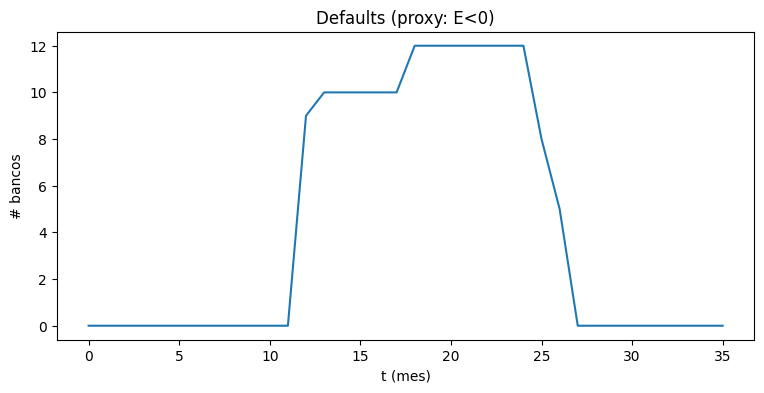

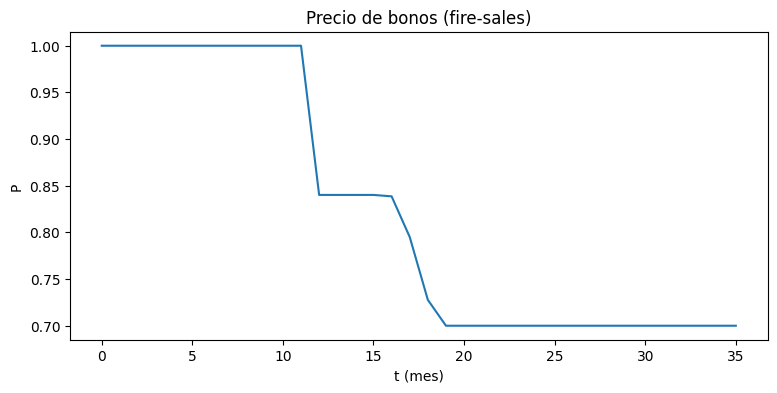

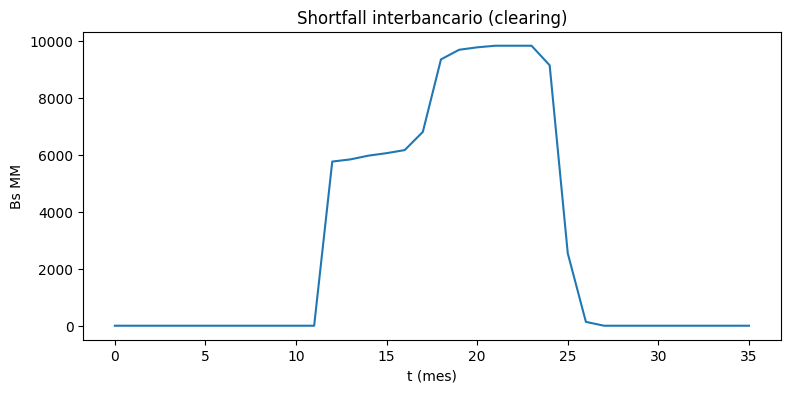

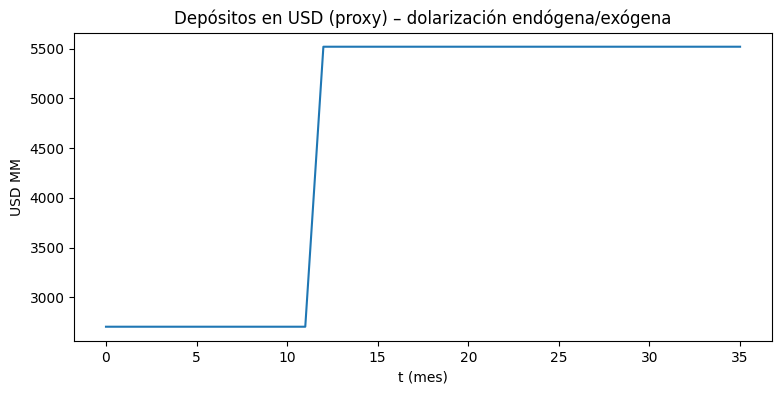

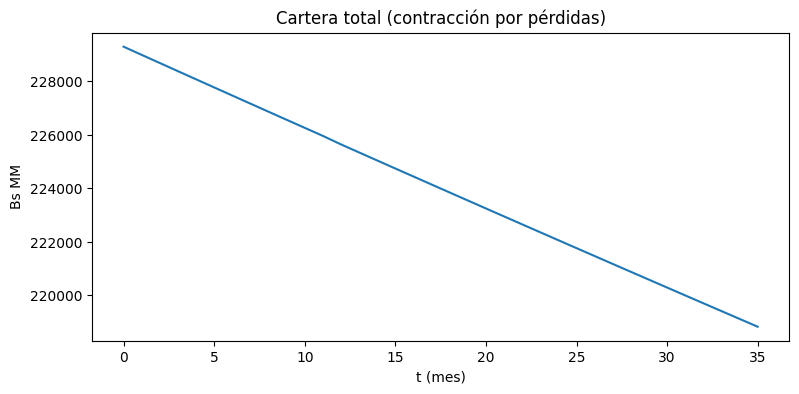

In [1]:
# ABM multicapa de contagio bancario (Bolivia-style)
# - Red interbancaria + clearing tipo Eisenberg–Noe
# - Corrida (retiros) + dolarización endógena
# - Fire-sales de bonos (precio endógeno)
# - Facilidad BCB en USD con pool limitado (divisas líquidas)
#
# Requisitos: numpy, pandas, networkx, matplotlib

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# -----------------------------
# 1) Parámetros "Bolivia-style"
# -----------------------------
def default_params():
    # Anclas nominales (ASFI / BCB); escala en millones de Bs, y USD en millones
    A_sys_bs = 328_006.0        # activos sistema (Bs MM)
    D_sys_bs = 224_106.0        # depósitos sistema (Bs MM)
    L_sys_bs = 226_721.0        # cartera sistema (Bs MM)

    params = dict(
        seed=7,
        n_banks=12,                 # 11 privados + 1 público (proxy)
        public_bank_index=0,        # banco 0: público
        A_sys_bs=A_sys_bs,
        D_sys_bs=D_sys_bs,
        L_sys_bs=L_sys_bs,

        # Dolarización / FX
        fx_dep_share=0.084,         # depósitos en ME / total depósitos
        fx_loan_share=0.004,        # créditos en ME / total créditos (muy bajo)
        e0=6.96,                    # Bs/USD (venta) como valuación
        rin_fx_usd=504.8,           # divisas líquidas (USD MM) ~ pool para stress test
        fx_facility_haircut=0.10,   # haircut operativo para asistencia (simple)

        # Estructura de balance (shares sobre activos)
        loan_share=0.70,
        bond_share=0.15,
        cash_share=0.10,
        interbank_asset_share=0.03,
        fx_asset_share=0.02,

        # Capital (proxy)
        equity_share=0.10,          # E/A aproximado (no es CAR regulatorio, es proxy)
        car_floor=0.10,             # umbral "mínimo" regulatorio (proxy)
        car_run_threshold=0.11,     # umbral para gatillar corrida
        run_base=0.003,             # corrida base (mensual)
        run_stress=0.030,           # extra si CAR bajo

        # Riesgo de crédito (loss rate mensual)
        loss0=0.0012,
        loss_pi=0.00010,
        loss_depr=0.00040,
        loss_recession=0.00025,
        informality=0.65,           # proxy (0-1): sensibilidad adicional

        # Fire-sales de bonos
        P0=1.0,
        Pmin=0.70,
        fire_alpha=0.35,            # severidad de impacto
        market_depth=25_000.0,      # "profundidad" (Bs MM de bonos para 100% del shock)

        # Interbank network
        ib_density=0.18,            # densidad aproximada
        ib_core_share=0.30,         # fracción de bancos en core
        ib_total_share_of_assets=0.03,  # pasivos interbancarios agregados / activos

        # Política del banco público (contracíclica)
        pub_bond_put=0.20,          # compra bonos cuando P cae (intensidad)
        pub_ib_put=0.15,            # presta a bancos estresados (intensidad)
        pub_car_min=0.105,          # regla prudencial del banco público

        # Horizonte
        T=36,
        regime_switch_t=12,         # shock "corrida a dolarización"
        shock_depr=0.20,            # depreciación (log-approx) en el cambio de régimen
        shock_pi=0.015,             # salto de inflación mensual (pp) tras régimen
        shock_fx_shift=0.12,        # aumento exógeno del share FX (puntos)
    )
    return params


# -----------------------------
# 2) Inicialización de bancos
# -----------------------------
def make_banks(params):
    rng = np.random.default_rng(params["seed"])
    n = params["n_banks"]

    # Tamaños heterogéneos (Zipf-like) y re-escala a activos del sistema
    ranks = np.arange(1, n + 1)
    size_raw = 1 / (ranks ** 0.9)
    size = size_raw / size_raw.sum()
    A = size * params["A_sys_bs"]

    # Componentes de activos
    L = params["loan_share"] * A
    B = params["bond_share"] * A
    C = params["cash_share"] * A
    IA = params["interbank_asset_share"] * A
    FXA_usd = (params["fx_asset_share"] * A) / params["e0"]

    # Depósitos y otros pasivos (calibra D/A)
    D_total = (params["D_sys_bs"] / params["A_sys_bs"]) * A
    D_fx_usd = (params["fx_dep_share"] * D_total) / params["e0"]
    D_mn = D_total - params["e0"] * D_fx_usd

    # Interbank liabilities target y otros pasivos para cuadrar patrimonio
    IL = params["ib_total_share_of_assets"] * A
    E = params["equity_share"] * A

    # Otros pasivos O: balance identity
    # A = D + IL + O + E  => O = A - D - IL - E
    O = A - (D_mn + params["e0"] * D_fx_usd) - IL - E
    O = np.maximum(O, 0.0)

    banks = pd.DataFrame({
        "bank": [f"B{i}" for i in range(n)],
        "is_public": [1 if i == params["public_bank_index"] else 0 for i in range(n)],
        "A_bs": A,
        "L_bs": L,
        "B_units": B,          # en "unidades" con P=1 al inicio
        "C_bs": C,
        "IA_bs": IA,
        "FXA_usd": FXA_usd,
        "D_mn_bs": D_mn,
        "D_fx_usd": D_fx_usd,
        "IL_bs": IL,
        "O_bs": O,
        "E_bs": E,
    })

    return banks


# -----------------------------------------
# 3) Red interbancaria (core–periphery)
# -----------------------------------------
def make_interbank_matrix(banks, params):
    rng = np.random.default_rng(params["seed"] + 1)
    n = len(banks)

    # Define core set
    core_k = max(2, int(np.round(params["ib_core_share"] * n)))
    core = set(np.argsort(banks["A_bs"].values)[-core_k:])  # los más grandes

    # Matriz de obligaciones W_ij: i debe a j (liabilities)
    W = np.zeros((n, n))

    # Total pasivos interbancarios por banco = IL_bs
    IL = banks["IL_bs"].values.copy()

    # Probabilidades de enlace: core-core alto, periphery-core medio, periphery-periphery bajo
    def link_prob(i, j):
        if i == j:
            return 0.0
        i_core, j_core = (i in core), (j in core)
        if i_core and j_core:
            return 0.55
        if (not i_core) and j_core:
            return 0.35
        if i_core and (not j_core):
            return 0.25
        return 0.10

    # Genera enlaces y asigna pesos; respeta IL por fila (deudor)
    for i in range(n):
        # candidatos
        probs = np.array([link_prob(i, j) for j in range(n)], dtype=float)
        probs /= probs.sum()

        # número de acreedores por deudor i
        m = max(1, int(np.round(params["ib_density"] * (n - 1))))
        creditors = rng.choice(np.arange(n), size=m, replace=False, p=probs)

        # pesos por tamaño del acreedor (preferencia por bancos grandes)
        w = banks.loc[creditors, "A_bs"].values
        w = w / w.sum()

        W[i, creditors] = IL[i] * w

    # Activos interbancarios implícitos: sum_j W[j,i]
    banks["IA_bs"] = W.sum(axis=0)

    return W, banks


# -----------------------------------------
# 4) Métricas: capital proxy + estrés
# -----------------------------------------
def compute_car(banks, P, e, weights=(0.75, 0.10, 0.20, 0.10)):
    wL, wB, wIA, wFX = weights
    RWA = (wL * banks["L_bs"]
           + wB * (P * banks["B_units"])
           + wIA * banks["IA_bs"]
           + wFX * (e * banks["FXA_usd"]))
    A = banks["L_bs"] + P * banks["B_units"] + banks["C_bs"] + banks["IA_bs"] + e * banks["FXA_usd"]
    Liab = banks["D_mn_bs"] + e * banks["D_fx_usd"] + banks["IL_bs"] + banks["O_bs"]
    E = A - Liab
    banks["E_bs"] = E
    banks["CAR"] = np.where(RWA > 1e-9, E / RWA, 0.0)
    banks["A_bs_mtm"] = A
    banks["RWA_bs"] = RWA
    return banks


def system_stress(banks, car_thr):
    return float((banks["CAR"] < car_thr).mean())


# -----------------------------------------
# 5) Shocks macro y pérdida de cartera
# -----------------------------------------
def loss_rate(params, pi, dlog_e, g):
    # proxy mensual
    rec = max(0.0, -g)
    return (params["loss0"]
            + params["loss_pi"] * pi
            + params["loss_depr"] * dlog_e
            + params["loss_recession"] * rec
            + 0.00020 * params["informality"])


def apply_credit_losses(banks, ell):
    # reduce L y pega a patrimonio vía caída de activos
    banks["L_bs"] *= (1.0 - ell)
    return banks


# -----------------------------------------
# 6) Corrida + conversión a USD (dolarización)
# -----------------------------------------
def deposit_run_and_dollarize(banks, params, P, e, stress, fx_pool_usd, fx_shift=0.0):
    """
    - Retiro: reduce D_mn y/o D_fx (si hay corrida).
    - Dolarización: migra parte de D_mn -> D_fx (demanda USD).
    - El banco paga con FXA si alcanza; si no, usa pool BCB (fx_pool_usd).
      Si aun no alcanza, vende bonos para obtener Bs y compra USD (aprox) => fire-sales.
    Retorna: bancos actualizados, fx_pool_usd restante, ventas de bonos agregadas (en unidades).
    """
    n = len(banks)
    bond_sales_units = np.zeros(n)

    # corrida: mayor si CAR bajo
    run = params["run_base"] + params["run_stress"] * (banks["CAR"] < params["car_run_threshold"]).astype(float)

    # dolarización exógena adicional (escenario de régimen)
    # migra un porcentaje de D_mn hacia D_fx
    dollarize_frac = np.clip(fx_shift, 0.0, 0.30)

    for i in range(n):
        # 1) retiros (MN): se pagan con caja; si no alcanza, con venta de bonos
        wdraw_mn = run.iloc[i] * banks.loc[i, "D_mn_bs"]
        banks.loc[i, "D_mn_bs"] -= wdraw_mn

        pay_mn = wdraw_mn
        if banks.loc[i, "C_bs"] >= pay_mn:
            banks.loc[i, "C_bs"] -= pay_mn
        else:
            short = pay_mn - banks.loc[i, "C_bs"]
            banks.loc[i, "C_bs"] = 0.0
            # vende bonos para cubrir short
            units = short / max(P, 1e-6)
            sell = min(units, banks.loc[i, "B_units"])
            banks.loc[i, "B_units"] -= sell
            bond_sales_units[i] += sell
            # si aún falta (muy raro con calibración), se deja como estrés adicional
            # (podrías modelar incumplimiento a depositantes aquí)

        # 2) migración a USD: convierte fracción de D_mn a D_fx
        conv_mn = dollarize_frac * banks.loc[i, "D_mn_bs"]
        banks.loc[i, "D_mn_bs"] -= conv_mn
        need_usd = conv_mn / max(e, 1e-6)

        # Paga conversión con FXA primero
        if banks.loc[i, "FXA_usd"] >= need_usd:
            banks.loc[i, "FXA_usd"] -= need_usd
            banks.loc[i, "D_fx_usd"] += need_usd
        else:
            need_left = need_usd - banks.loc[i, "FXA_usd"]
            banks.loc[i, "D_fx_usd"] += need_usd
            banks.loc[i, "FXA_usd"] = 0.0

            # Usa pool de divisas del BCB
            take = min(need_left, fx_pool_usd)
            fx_pool_usd -= take
            need_left -= take

            # Si aún falta, fuerza venta de bonos para “comprar USD”
            if need_left > 1e-9:
                # vende bonos por Bs y compra USD al tipo e (aprox)
                need_bs = need_left * e
                units = need_bs / max(P, 1e-6)
                sell = min(units, banks.loc[i, "B_units"])
                banks.loc[i, "B_units"] -= sell
                bond_sales_units[i] += sell
                # En este esquema, asumimos que logra comprar USD (aunque sea caro).
                # Si sell<units, quedó racionado: modela default operativo (opcional).

    return banks, fx_pool_usd, bond_sales_units.sum()


# -----------------------------------------
# 7) Fire-sales: precio de bonos endógeno
# -----------------------------------------
def update_bond_price(P, total_sales_units, params):
    # ventas en unidades ~ Bs cuando P~1; re-escala por "market_depth"
    impact = params["fire_alpha"] * (total_sales_units / max(params["market_depth"], 1e-9))
    P_new = max(params["Pmin"], P * (1.0 - impact))
    return P_new


# -----------------------------------------
# 8) Clearing interbancario (Eisenberg–Noe)
# -----------------------------------------
def eisenberg_noe_clearing(W, x, max_iter=10_000, tol=1e-8):
    """
    W[i,j]: i debe a j
    x[i]: activos externos netos (excluye pagos interbancarios)
    Retorna p: pagos de cada i hacia el sistema (total pagado a acreedores)
    """
    n = W.shape[0]
    pbar = W.sum(axis=1)
    Pi = np.zeros_like(W)
    for i in range(n):
        if pbar[i] > 0:
            Pi[i, :] = W[i, :] / pbar[i]

    p = pbar.copy()
    for _ in range(max_iter):
        p_new = np.minimum(pbar, np.maximum(0.0, x + Pi.T @ p))
        if np.max(np.abs(p_new - p)) < tol:
            p = p_new
            break
        p = p_new
    return p, pbar, Pi


def apply_interbank_clearing(banks, W, P, e):
    # x_i: activos externos netos (excluye pagos interbancarios)
    A_ext = banks["L_bs"] + P * banks["B_units"] + banks["C_bs"] + e * banks["FXA_usd"]
    L_ext = banks["D_mn_bs"] + e * banks["D_fx_usd"] + banks["O_bs"]
    x = (A_ext - L_ext).values

    p, pbar, Pi = eisenberg_noe_clearing(W, x)

    # cobros interbancarios recibidos
    received = Pi.T @ p

    # actualiza activos interbancarios a "valor recibido" (mark-to-clearing)
    banks["IA_bs"] = received

    # pasivos interbancarios se mantienen como pbar (nominal), pero pagos efectivos p
    banks["IL_bs"] = pbar

    # pérdida para acreedores ya se refleja vía IA_bs; deudores en stress no pagan completo.
    banks["ib_payment"] = p
    banks["ib_pbar"] = pbar
    banks["ib_shortfall"] = pbar - p

    return banks


# -----------------------------------------
# 9) Banco público: estabilizador (simple)
# -----------------------------------------
def public_bank_actions(banks, params, P, stress):
    pub = params["public_bank_index"]
    if banks.loc[pub, "is_public"] != 1:
        return banks, 0.0

    # si su CAR está sano, actúa
    if banks.loc[pub, "CAR"] < params["pub_car_min"]:
        return banks, 0.0

    # 1) compra bonos cuando P cae (inyecta demanda y reduce fire-sales)
    buy_units = params["pub_bond_put"] * max(0.0, 1.0 - P) * banks.loc[pub, "A_bs"]
    buy_units = buy_units / max(P, 1e-6)
    buy_cost = buy_units * P

    if banks.loc[pub, "C_bs"] >= buy_cost:
        banks.loc[pub, "C_bs"] -= buy_cost
        banks.loc[pub, "B_units"] += buy_units

    # 2) presta MN a bancos estresados (muy simplificado): transfiere caja
    lend_total = params["pub_ib_put"] * stress * banks.loc[pub, "C_bs"]
    if lend_total > 0:
        stressed = banks.index[banks["CAR"] < params["car_run_threshold"]].tolist()
        stressed = [i for i in stressed if i != pub]
        if stressed:
            per = lend_total / len(stressed)
            if banks.loc[pub, "C_bs"] >= lend_total:
                banks.loc[pub, "C_bs"] -= lend_total
                banks.loc[stressed, "C_bs"] += per

    return banks, buy_units


# -----------------------------------------
# 10) Simulación completa
# -----------------------------------------
def simulate(params):
    banks = make_banks(params)
    W, banks = make_interbank_matrix(banks, params)

    # series macro (puedes reemplazar por datos/escenarios)
    T = params["T"]
    pi = np.full(T, 0.006)     # inflación mensual base (0.6%)
    g  = np.full(T, 0.002)     # crecimiento mensual proxy
    dlog_e = np.zeros(T)
    e = np.zeros(T)
    e[0] = params["e0"]

    for t in range(1, T):
        e[t] = e[t-1] * np.exp(dlog_e[t])

    # régimen: shock de depreciación e inflación y corrida a dolarización
    Tstar = params["regime_switch_t"]
    if 0 <= Tstar < T:
        dlog_e[Tstar] = np.log(1.0 + params["shock_depr"])
        for t in range(Tstar, T):
            e[t] = e[t-1] * np.exp(dlog_e[t])
        pi[Tstar:] += params["shock_pi"]
        g[Tstar:]  -= 0.003  # desaceleración

    # precio de bonos
    P = params["P0"]

    # pool de USD (divisas líquidas) para facilitar conversiones
    fx_pool_usd = params["rin_fx_usd"]

    out = []

    for t in range(T):
        # 1) MTM + CAR
        banks = compute_car(banks, P=P, e=e[t])
        stress = system_stress(banks, params["car_run_threshold"])

        # 2) Política del banco público (amortigua)
        banks, _ = public_bank_actions(banks, params, P, stress)

        # 3) Pérdidas de cartera por macro + informalidad
        ell = loss_rate(params, pi[t], dlog_e[t], g[t])
        banks = apply_credit_losses(banks, ell)

        # 4) Recalcula CAR y ejecuta corrida + dolarización (en régimen)
        banks = compute_car(banks, P=P, e=e[t])
        stress = system_stress(banks, params["car_run_threshold"])

        fx_shift = params["shock_fx_shift"] if t == Tstar else 0.0
        banks, fx_pool_usd, total_sales = deposit_run_and_dollarize(
            banks, params, P=P, e=e[t], stress=stress, fx_pool_usd=fx_pool_usd, fx_shift=fx_shift
        )

        # 5) Fire-sales actualiza precio de bonos
        P = update_bond_price(P, total_sales, params)

        # 6) Clearing interbancario
        banks = apply_interbank_clearing(banks, W, P=P, e=e[t])

        # 7) MTM final del periodo
        banks = compute_car(banks, P=P, e=e[t])
        stress = system_stress(banks, params["car_run_threshold"])

        # defaults (proxy): E<0
        defaults = int((banks["E_bs"] < 0).sum())
        ib_shortfall = float(banks["ib_shortfall"].sum())

        out.append(dict(
            t=t,
            e=e[t],
            pi=pi[t],
            g=g[t],
            P_bond=P,
            stress=stress,
            defaults=defaults,
            fx_pool_usd=fx_pool_usd,
            ib_shortfall=ib_shortfall,
            credit_total=float(banks["L_bs"].sum()),
            deposits_mn=float(banks["D_mn_bs"].sum()),
            deposits_fx_usd=float(banks["D_fx_usd"].sum()),
            car_min=float(banks["CAR"].min()),
            car_p25=float(banks["CAR"].quantile(0.25)),
        ))

    return pd.DataFrame(out), banks


# -----------------------------
# 11) Ejecuta y grafica
# -----------------------------
params = default_params()
ts, banks_end = simulate(params)

print(ts.tail(5))

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(ts["t"], ts["defaults"])
ax.set_title("Defaults (proxy: E<0)")
ax.set_xlabel("t (mes)")
ax.set_ylabel("# bancos")
plt.show()

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(ts["t"], ts["P_bond"])
ax.set_title("Precio de bonos (fire-sales)")
ax.set_xlabel("t (mes)")
ax.set_ylabel("P")
plt.show()

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(ts["t"], ts["ib_shortfall"])
ax.set_title("Shortfall interbancario (clearing)")
ax.set_xlabel("t (mes)")
ax.set_ylabel("Bs MM")
plt.show()

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(ts["t"], ts["deposits_fx_usd"])
ax.set_title("Depósitos en USD (proxy) – dolarización endógena/exógena")
ax.set_xlabel("t (mes)")
ax.set_ylabel("USD MM")
plt.show()

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(ts["t"], ts["credit_total"])
ax.set_title("Cartera total (contracción por pérdidas)")
ax.set_xlabel("t (mes)")
ax.set_ylabel("Bs MM")
plt.show()


# ABM macro-financiero para Bolivia: escenarios, equilibrio y robustez (macro + contagio bancario)

## 1) ¿Qué significa “equilibrio” en un ABM macro-financiero?
En un ABM no imponemos un equilibrio walrasiano cerrado; trabajamos con un proceso estocástico de alta dimensión. Por ello, usamos una definición operacional de equilibrio como **steady state estadístico**:

- **Equilibrio macro (steady state):** promedios estables (en ventana larga) para $g_t$ (crecimiento), $\pi_t$ (inflación), $\Delta \ln e_t$ (depreciación) y desempleo $u_t$, con variabilidad acotada.  
- **Equilibrio financiero (steady state):** el sistema converge a un régimen con:
  - baja probabilidad de defaults bancarios,
  - ratios de capital (proxy) por encima de umbrales ($CAR_i \ge \kappa$ para la mayoría),
  - baja pérdida por contagio (shortfall interbancario),
  - precio de bonos $P^B_t$ estable (sin espiral de fire-sales),
  - pool de divisas líquidas (proxy $R^{FX}$) no agotado persistentemente.

En práctica, se mide con un conjunto de estadísticas sobre una ventana $t \in [T_{burn},T]$:
- Macro: $\bar g$, $\bar \pi$, $\overline{\Delta \ln e}$, $\bar u$ y sus volatilidades.
- Financiero: $\min CAR$, $\%(\,CAR<\kappa\,)$, #defaults, shortfall interbancario agregado, $\min P^B$, agotamiento de divisas.

---

## 2) Estructura del modelo (feedback macro-financiero)
El modelo combina:
1) **Capa bancaria (contagio):** red interbancaria + clearing tipo Eisenberg–Noe, fire-sales de bonos, corrida de depósitos y conversión a USD, restricción de divisas (pool).  
2) **Capa macro:** $Y_t$ y $g_t$ dependen del crédito y del estrés financiero; $\pi_t$ responde a output gap y pass-through del FX; $\Delta \ln e_t$ depende de demanda/suministro neto de FX y de intervención (muy simplificado).  
3) **Riesgo de crédito:** tasa de pérdida de cartera $\ell^L_t$ sube con inflación, depreciación, recesión y un proxy de informalidad $Inf$.

Ejemplo de cierres reducidos (sólo para documentación):
- Pérdida de cartera:
  $ \ell^L_t = \ell_0 + \ell_\pi \pi_t + \ell_e \Delta \ln e_t + \ell_g \max(0,-g_t) + \ell_{inf}\,Inf $
- Output:
  $ g_{t+1} = \bar g + \varphi_C \Delta \ln Credit_t - \varphi_S Stress_t + \varepsilon^g_t$
- Inflación:
  $ \pi_{t+1} = \pi^\star + \kappa_y \tilde y_t + \psi_e \Delta \ln e_t + \varepsilon^\pi_t $
- Dolarización (share FX depósitos):
  $ s^{FX}_{t+1} = \sigma(\eta_0 + \eta_1 \Delta \ln e_t + \eta_2 \pi_t + \eta_3 Stress_t)$

---

## 3) Escenarios (stress testing) para Bolivia
### 3.1 Bloques de shocks (modulares)
A) **FX & dolarización**
- (A1) “Corrida a USD”: salto exógeno en conversión MN→USD ($\Delta s^{FX}$) + aumento de $\eta_1$ (sensibilidad a depreciación).
- (A2) “Restricción de divisas”: caída del pool $R^{FX}$ (divisas líquidas), racionamiento y ventas forzadas.

B) **Soberano / bonos**
- (B1) “Sovereign repricing”: shock negativo a $P^B$ y/o menor profundidad de mercado (mayor impacto fire-sales).
- (B2) “Doom loop”: bancos aumentan tenencia de bonos en recesión (opcional).

C) **Crédito & informalidad**
- (C1) “Deterioro de cartera”: aumento de $\ell_0$ y/o $\ell_{inf}$.
- (C2) “Shock real”: caída en $\bar g$ (demanda) que eleva mora y estrés.

D) **Red interbancaria**
- (D1) “Concentración”: red más core-periphery (más fragilidad a default de bancos grandes).
- (D2) “Exposición cruzada”: mayor share interbancario.

E) **Política y mitigación**
- (E1) “Banco público market-maker”: compra bonos cuando $P^B$ cae y presta a bancos estresados (sujeto a capital).
- (E2) “LOLR en MN”: facilidad de liquidez que reduce fire-sales.
- (E3) “Macroprudencial FX”: encaje/costo que reduce conversión a USD (reduce $\Delta s^{FX}$ efectiva).

### 3.2 Paquete de escenarios recomendados (para paper)
- S0 Baseline (Bolivia-style).
- S1 FX shock: (A2) + depreciación moderada.
- S2 Corrida a USD: (A1) + (A2).
- S3 Sovereign stress: (B1) + menor profundidad.
- S4 Credit deterioration: (C1) con alta informalidad.
- S5 “Perfect storm”: S2 + S3 + S4.
- S6/S7/S8: repetir S5 con (E1) / (E2) / (E3) activados y comparar.

---

## 4) Robustez y sensibilidad
Para sostener el paper:
- **Monte Carlo:** repetir cada escenario con múltiples semillas y reportar probabilidades:
  - $\Pr(\#defaults \ge 2)$, $\Pr(P^B_{min}<\bar P)$, $\Pr(R^{FX}=0)$.
- **Sensibilidad local:** barrido (grid) sobre:
  - severidad fire-sales $\alpha$,
  - profundidad $Depth$,
  - pool FX $R^{FX}$,
  - exposición interbancaria,
  - intensidad de corrida,
  - regla del banco público.

Output final: tabla de resultados + gráficos y, si quieres, “frontier plot” riesgo-política (trade-off estabilidad vs costo fiscal).



                        scenario    g_mean   pi_mean  dloge_mean  stress_mean  \
0                    S0_baseline -0.014582  0.006234    0.020529     0.551587   
1          S1_fx_liquidity_shock -0.014582  0.006238    0.020576     0.551587   
2                  S2_run_to_usd -0.027357  0.006051    0.031482     1.000000   
3            S3_sovereign_stress -0.014523  0.006284    0.020970     0.549603   
4        S4_credit_deterioration -0.020554  0.006291    0.027074     0.742063   
5               S5_perfect_storm -0.027591  0.006110    0.032303     1.000000   
6  S6_storm_public_bank_stronger -0.027591  0.006104    0.032245     1.000000   
7               S7_storm_lolr_mn -0.027531  0.006109    0.032229     1.000000   
8          S8_storm_macroprud_fx -0.027591  0.006110    0.032303     1.000000   

   car_min_min  defaults_max  Pbond_min  fx_pool_min  event_defaults_ge2  \
0    -0.019937             5        0.7        505.0                   1   
1    -0.020245             5        0

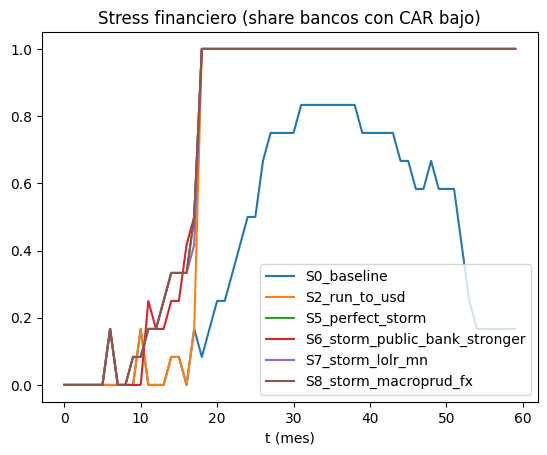

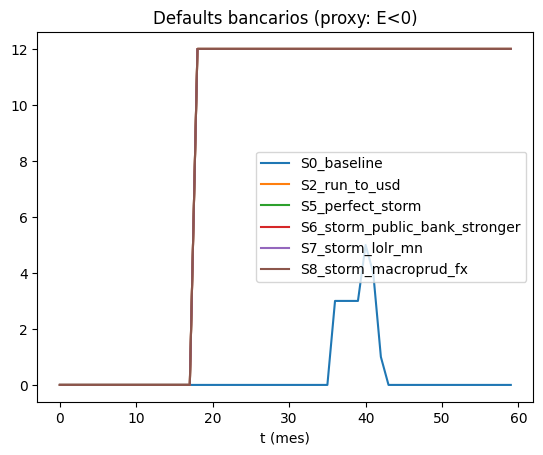

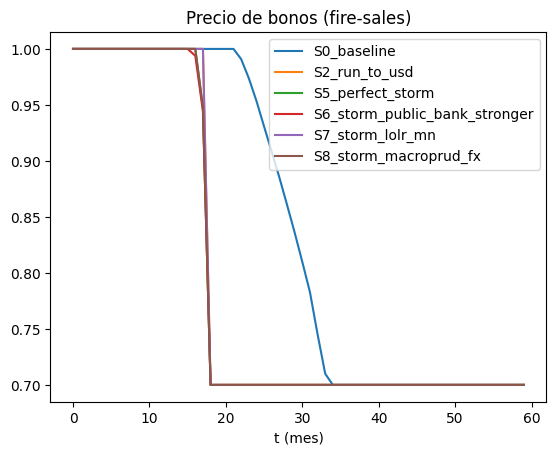

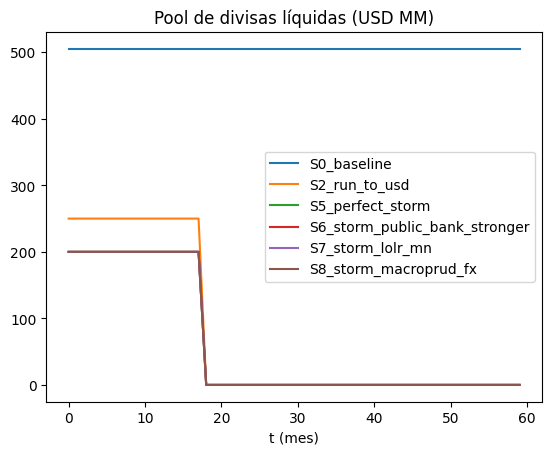

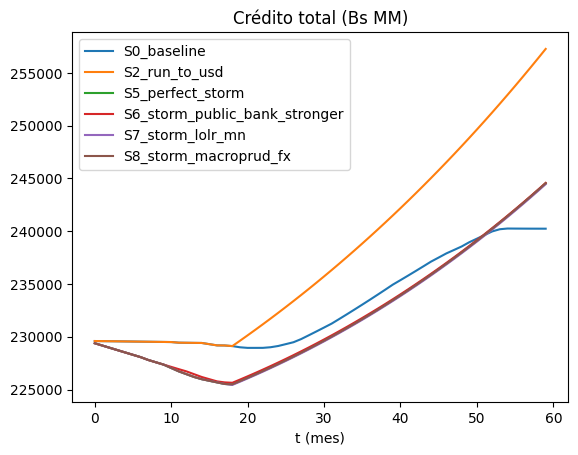

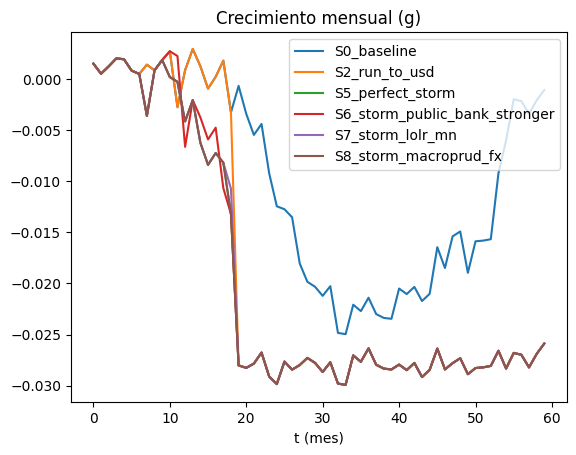

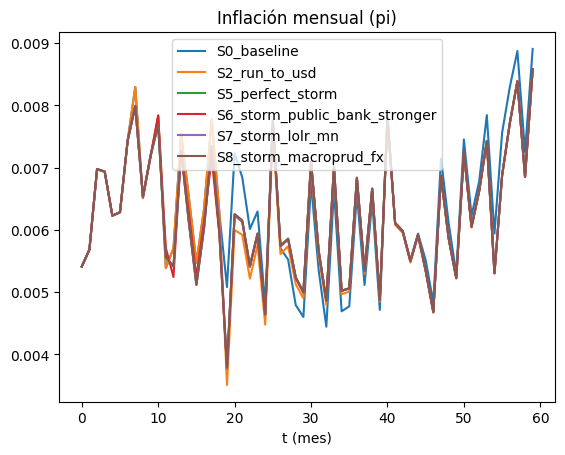

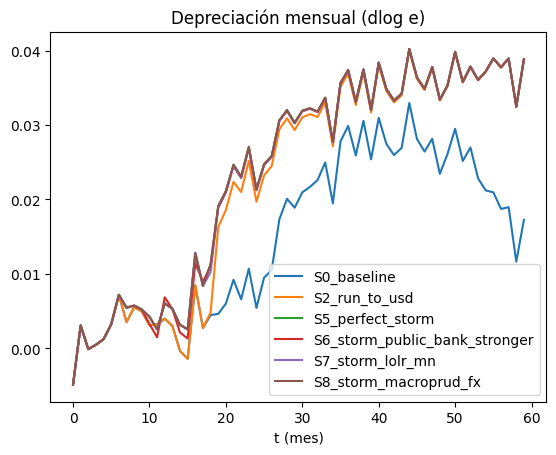

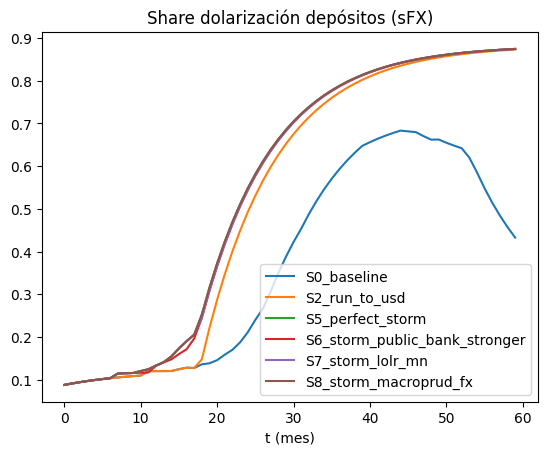

In [ ]:
# ============================================================
# ABM Macro-Financiero Bolivia: escenarios + equilibrio + robustez
# - Red interbancaria + clearing Eisenberg–Noe
# - Corrida + dolarización + restricción de divisas
# - Fire-sales de bonos con precio endógeno
# - Feedback macro: crecimiento, inflación, FX, crédito
# - Banco público + LOLR MN + macroprudencial FX (opcional)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Utilidades
# -----------------------------
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def clip(x, lo, hi):
    return max(lo, min(hi, x))

# -----------------------------
# Parámetros base "Bolivia-style"
# (Escala: Bs MM, USD MM)
# -----------------------------
def base_params():
    return dict(
        seed=7,
        T=60,
        burn=18,

        # Sistema (escalas)
        n_banks=12,
        public_bank_index=0,
        A_sys_bs=328_006.0,
        D_sys_bs=224_106.0,
        e0=6.96,

        # Bolivianización (proxy)
        fx_dep_share=0.084,
        fx_loan_share=0.004,

        # Pool de divisas líquidas (proxy, USD MM)
        fx_pool_usd0=505.0,

        # Balance shares
        loan_share=0.70,
        bond_share=0.15,
        cash_share=0.10,
        fx_asset_share=0.02,          # activos FX como share de A
        ib_liab_share=0.03,           # IL/A (exposición interbancaria)

        # Capital / umbrales (proxies)
        equity_share=0.10,            # E/A aproximado
        kappa=0.12,                   # umbral prudencial proxy
        run_car_thr=0.11,

        # Risk weights (proxy)
        wL=0.75, wB=0.10, wIA=0.20, wFX=0.10,

        # Corrida (retiros MN) y dolarización (conversión MN->USD)
        run_base=0.002,
        run_stress=0.020,             # aumenta si CAR bajo
        # dolarización endógena (share sFX en depósitos del sistema)
        eta0=-2.0, eta1=6.0, eta2=3.0, eta3=4.0,
        sfx0=0.084,
        # política macroprudencial FX reduce conversiones efectivas
        fx_macroprud_buffer=0.0,      # (0..1) reduce shock de conversión

        # Fire-sales bonos
        P0=1.0,
        Pmin=0.70,
        fire_alpha=0.35,
        market_depth=25_000.0,        # profundidad (Bs MM en unidades P~1)

        # Interbank network (core-periphery sintético)
        ib_density=0.18,
        ib_core_share=0.30,

        # Banco público: market-maker + liquidez
        enable_public_bank=True,
        pub_car_min=0.105,
        pub_bond_put=0.20,            # compra bonos si P cae
        pub_liq_put=0.15,             # transfiere caja a bancos estresados

        # LOLR MN (reduce ventas forzadas de bonos al cubrir retiros)
        enable_lolr_mn=False,
        lolr_mn_cap_share=0.015,      # % de Y como cap por periodo
        lolr_haircut=0.10,

        # Macro block (reducido)
        gbar=0.002,                   # crecimiento base mensual
        pi_star=0.006,                # 0.6% mensual
        kappa_y=0.10,                 # Phillips reducida (muy simple)
        psi_e=0.10,                   # pass-through FX
        phi_credit=0.05,              # crecimiento responde a crédito
        phi_stress=0.03,              # crecimiento cae con stress
        sig_g=0.001,                  # shocks pequeños
        sig_pi=0.001,

        # FX block (reducido)
        chi_fx=0.20,                  # sensibilidad del FX neto
        chi_int=0.30,                 # intervención (si se activa)
        enable_fx_intervention=False,

        # Crédito: pérdidas (informalidad)
        informality=0.65,
        loss0=0.0012,
        loss_pi=0.00010,
        loss_depr=0.00040,
        loss_recession=0.00025,
        loss_inf=0.00020,             # sensibilidad a informalidad

        # Oferta de crédito (endógena)
        gL_priv=0.001,
        gL_pub=0.002,
        credit_stress_slope=0.015     # bancos privados reducen gL cuando stress sube
    )

# -----------------------------
# Inicialización bancos (sintética, escalada al sistema)
# -----------------------------
def init_banks(P, rng):
    n = P["n_banks"]
    ranks = np.arange(1, n + 1)
    size_raw = 1 / (ranks ** 0.9)
    size = size_raw / size_raw.sum()
    A = size * P["A_sys_bs"]

    L = P["loan_share"] * A
    B = P["bond_share"] * A         # unidades con P=1
    C = P["cash_share"] * A
    FXA_usd = (P["fx_asset_share"] * A) / P["e0"]

    # Depósitos totales consistentes con D_sys/A_sys
    D_total = (P["D_sys_bs"] / P["A_sys_bs"]) * A
    D_fx_usd = (P["fx_dep_share"] * D_total) / P["e0"]
    D_mn = D_total - P["e0"] * D_fx_usd

    IL = P["ib_liab_share"] * A
    E = P["equity_share"] * A
    O = A - (D_mn + P["e0"] * D_fx_usd) - IL - E
    O = np.maximum(O, 0.0)

    df = pd.DataFrame({
        "i": np.arange(n),
        "is_public": (np.arange(n) == P["public_bank_index"]).astype(int),
        "A": A, "L": L, "B": B, "C": C,
        "FXA": FXA_usd,
        "Dmn": D_mn, "Dfx": D_fx_usd,
        "IL": IL, "O": O, "E": E
    })
    return df

# -----------------------------
# Red interbancaria core-periphery: W[i,j] = obligación de i hacia j
# -----------------------------
def init_interbank_W(banks, P, rng):
    n = len(banks)
    core_k = max(2, int(round(P["ib_core_share"] * n)))
    core = set(np.argsort(banks["A"].values)[-core_k:])

    def link_prob(i, j):
        if i == j:
            return 0.0
        i_core, j_core = (i in core), (j in core)
        if i_core and j_core: return 0.55
        if (not i_core) and j_core: return 0.35
        if i_core and (not j_core): return 0.25
        return 0.10

    W = np.zeros((n, n))
    IL = banks["IL"].values.copy()
    m = max(1, int(round(P["ib_density"] * (n - 1))))

    for i in range(n):
        probs = np.array([link_prob(i, j) for j in range(n)], dtype=float)
        probs = probs / probs.sum()
        creditors = rng.choice(np.arange(n), size=m, replace=False, p=probs)

        w = banks.loc[creditors, "A"].values
        w = w / w.sum()
        W[i, creditors] = IL[i] * w

    # Activos interbancarios
    banks["IA"] = W.sum(axis=0)
    return W, banks

# -----------------------------
# Balance MTM + CAR proxy
# -----------------------------
def mark_to_market_and_car(banks, Pbond, e, P):
    A = banks["L"] + Pbond * banks["B"] + banks["C"] + banks["IA"] + e * banks["FXA"]
    Liab = banks["Dmn"] + e * banks["Dfx"] + banks["IL"] + banks["O"]
    E = A - Liab

    RWA = (P["wL"] * banks["L"]
           + P["wB"] * (Pbond * banks["B"])
           + P["wIA"] * banks["IA"]
           + P["wFX"] * (e * banks["FXA"]))

    banks["A_mtm"] = A
    banks["E"] = E
    banks["RWA"] = RWA
    banks["CAR"] = np.where(RWA > 1e-9, E / RWA, -1.0)
    return banks

def stress_index(banks, thr):
    return float((banks["CAR"] < thr).mean())

# -----------------------------
# Eisenberg–Noe clearing
# -----------------------------
def eisenberg_noe(W, x, tol=1e-10, max_iter=50_000):
    n = W.shape[0]
    pbar = W.sum(axis=1)
    Pi = np.zeros_like(W)
    for i in range(n):
        if pbar[i] > 0:
            Pi[i, :] = W[i, :] / pbar[i]
    p = pbar.copy()

    for _ in range(max_iter):
        p_new = np.minimum(pbar, np.maximum(0.0, x + Pi.T @ p))
        if np.max(np.abs(p_new - p)) < tol:
            p = p_new
            break
        p = p_new
    return p, pbar, Pi

def apply_clearing(banks, W, Pbond, e):
    A_ext = banks["L"] + Pbond * banks["B"] + banks["C"] + e * banks["FXA"]
    L_ext = banks["Dmn"] + e * banks["Dfx"] + banks["O"]
    x = (A_ext - L_ext).values

    p, pbar, Pi = eisenberg_noe(W, x)
    received = Pi.T @ p

    banks["IA"] = received
    banks["IL"] = pbar
    banks["ib_shortfall"] = pbar - p
    return banks

# -----------------------------
# Pérdidas de cartera (macro -> bancos)
# -----------------------------
def loss_rate(P, pi, dlog_e, g):
    rec = max(0.0, -g)
    return (P["loss0"]
            + P["loss_pi"] * pi
            + P["loss_depr"] * dlog_e
            + P["loss_recession"] * rec
            + P["loss_inf"] * P["informality"])

def apply_credit_losses(banks, ell):
    banks["L"] *= (1.0 - ell)
    return banks

# -----------------------------
# Oferta de crédito (bancos -> macro)
# Endógeno: nuevos préstamos crean depósitos MN (endogenous money simplificado)
# -----------------------------
def credit_supply_step(banks, P, stress, rng):
    # privados reducen crecimiento cuando stress sube; público lo aumenta
    gL_priv_eff = max(-0.01, P["gL_priv"] - P["credit_stress_slope"] * stress)
    gL_pub_eff  = min(0.02,  P["gL_pub"]  + 0.010 * stress)

    new_L = np.zeros(len(banks))
    for i in range(len(banks)):
        gL = gL_pub_eff if banks.loc[i, "is_public"] == 1 else gL_priv_eff
        add = max(0.0, gL) * banks.loc[i, "L"]
        new_L[i] = add

    # balance: L += new_L ; Dmn += new_L (creación de depósitos)
    banks["L"] += new_L
    banks["Dmn"] += new_L
    return banks, float(new_L.sum())

# -----------------------------
# Corrida MN + conversión a USD + LOLR MN opcional
# -----------------------------
def run_and_dollarize_step(banks, P, Pbond, e, stress, fx_pool_usd, shock_fx_conv=0.0):
    n = len(banks)
    bond_sales = 0.0
    lolr_used = 0.0

    # corrida MN
    run = P["run_base"] + P["run_stress"] * (banks["CAR"] < P["run_car_thr"]).astype(float)

    # conversión MN->USD efectiva (con macroprudencial buffer)
    fx_conv = max(0.0, shock_fx_conv - P["fx_macroprud_buffer"])
    fx_conv = clip(fx_conv, 0.0, 0.30)

    # LOLR MN cap por periodo (proxy: share de Y; aquí Y no está disponible aún, así que usamos escala A_sys)
    lolr_cap = (P["lolr_mn_cap_share"] * P["A_sys_bs"]) if P["enable_lolr_mn"] else 0.0

    for i in range(n):
        # 1) retiros MN
        wd = float(run.iloc[i] * banks.loc[i, "Dmn"])
        banks.loc[i, "Dmn"] -= wd

        # paga con caja; si no, usa LOLR (si hay) y/o vende bonos
        if banks.loc[i, "C"] >= wd:
            banks.loc[i, "C"] -= wd
        else:
            short = wd - banks.loc[i, "C"]
            banks.loc[i, "C"] = 0.0

            # LOLR MN si está habilitado (contra bonos con haircut)
            if lolr_cap > 0:
                take = min(short, lolr_cap)
                lolr_cap -= take
                lolr_used += take
                short -= take

            # vende bonos para cubrir lo restante
            if short > 1e-9:
                units = short / max(Pbond, 1e-9)
                sell = min(units, banks.loc[i, "B"])
                banks.loc[i, "B"] -= sell
                bond_sales += sell

        # 2) conversión MN -> USD
        conv_mn = fx_conv * banks.loc[i, "Dmn"]
        banks.loc[i, "Dmn"] -= conv_mn
        need_usd = conv_mn / max(e, 1e-9)

        # usa FXA primero
        if banks.loc[i, "FXA"] >= need_usd:
            banks.loc[i, "FXA"] -= need_usd
            banks.loc[i, "Dfx"] += need_usd
        else:
            left = need_usd - banks.loc[i, "FXA"]
            banks.loc[i, "Dfx"] += need_usd
            banks.loc[i, "FXA"] = 0.0

            # usa pool FX
            take = min(left, fx_pool_usd)
            fx_pool_usd -= take
            left -= take

            # si aún falta: fire-sales para comprar USD (aprox)
            if left > 1e-9:
                need_bs = left * e
                units = need_bs / max(Pbond, 1e-9)
                sell = min(units, banks.loc[i, "B"])
                banks.loc[i, "B"] -= sell
                bond_sales += sell
                # si sell < units, queda racionado (puedes marcar "evento operativo")
    return banks, fx_pool_usd, bond_sales, lolr_used

# -----------------------------
# Banco público: market-maker + liquidez
# -----------------------------
def public_bank_step(banks, P, Pbond, stress):
    if not P["enable_public_bank"]:
        return banks, 0.0

    pub = P["public_bank_index"]
    if banks.loc[pub, "is_public"] != 1:
        return banks, 0.0

    # no actúa si su CAR está bajo (prudencia)
    if banks.loc[pub, "CAR"] < P["pub_car_min"]:
        return banks, 0.0

    bought = 0.0
    # compra bonos si P cae (inyecta demanda, reduce espiral)
    buy_units = P["pub_bond_put"] * max(0.0, 1.0 - Pbond) * banks.loc[pub, "A"]
    buy_units = buy_units / max(Pbond, 1e-9)
    cost = buy_units * Pbond

    if banks.loc[pub, "C"] >= cost:
        banks.loc[pub, "C"] -= cost
        banks.loc[pub, "B"] += buy_units
        bought = buy_units

    # transfiere caja a bancos estresados (liquidez MN)
    lend = P["pub_liq_put"] * stress * banks.loc[pub, "C"]
    if lend > 0:
        stressed = banks.index[(banks["CAR"] < P["run_car_thr"]) & (banks["is_public"] == 0)].tolist()
        if stressed and banks.loc[pub, "C"] >= lend:
            per = lend / len(stressed)
            banks.loc[pub, "C"] -= lend
            banks.loc[stressed, "C"] += per

    return banks, bought

# -----------------------------
# Precio de bonos (fire-sales)
# -----------------------------
def update_bond_price(Pbond, sales_units, P):
    impact = P["fire_alpha"] * (sales_units / max(P["market_depth"], 1e-9))
    Pnew = max(P["Pmin"], Pbond * (1.0 - impact))
    return Pnew

# -----------------------------
# Bloque macro (reducido) + FX
# -----------------------------
def macro_step(P, Y, credit_total, credit_prev, stress, e, dlog_e, pi, rng):
    # crecimiento responde a crédito (canal financiero) y stress
    credit_g = 0.0 if credit_prev <= 0 else np.log(max(1e-9, credit_total) / max(1e-9, credit_prev))
    g = P["gbar"] + P["phi_credit"] * credit_g - P["phi_stress"] * stress + rng.normal(0, P["sig_g"])
    Y_new = max(1e-6, Y * np.exp(g))

    # output gap proxy contra promedio móvil (aquí simplificado como (g - gbar))
    y_gap = g - P["gbar"]

    # inflación
    pi_new = P["pi_star"] + P["kappa_y"] * y_gap + P["psi_e"] * dlog_e + rng.normal(0, P["sig_pi"])
    pi_new = clip(pi_new, -0.01, 0.05)

    return Y_new, g, pi_new

def fx_step(P, e, Y, sfx, pi, stress, fx_net_shock, rng):
    # dolarización endógena (share sfx) por logit
    sfx_des = sigmoid(P["eta0"] + P["eta1"] * fx_net_shock + P["eta2"] * pi + P["eta3"] * stress)
    sfx_new = 0.90 * sfx + 0.10 * sfx_des

    # FX net demand proxy: aumenta con sfx_new y stress
    # (sin balance externo completo; es un cierre reducido para “macro-financial feedback”)
    FX_net = (0.15 * sfx_new + 0.05 * stress) * Y
    dlog_e = P["chi_fx"] * (FX_net / max(1e-9, Y)) + rng.normal(0, 0.003)

    e_new = e * np.exp(dlog_e)
    return e_new, dlog_e, sfx_new

# -----------------------------
# Runner de un escenario
# -----------------------------
def run_one(P, scenario):
    P = dict(P)  # copia
    rng = np.random.default_rng(P["seed"] + scenario.get("seed_shift", 0))

    # aplicar overrides del escenario
    for k, v in scenario.get("overrides", {}).items():
        P[k] = v

    banks = init_banks(P, rng)
    W, banks = init_interbank_W(banks, P, rng)

    # estados macro
    T = P["T"]
    Y = 1.0
    pi = P["pi_star"]
    e = P["e0"]
    sfx = P["sfx0"]
    fx_pool = P["fx_pool_usd0"]
    Pbond = P["P0"]

    credit_prev = float(banks["L"].sum())

    rows = []
    for t in range(T):
        # shock schedules
        shock = scenario.get("shocks", {}).get(t, {})
        shock_fx_conv = shock.get("fx_conv", 0.0)       # conversión MN->USD exógena
        shock_Pbond = shock.get("Pbond", 0.0)           # shock directo a precio bono (repricing)
        fx_net_shock = shock.get("fx_net", 0.0)         # shock “expectativas FX” para logit
        # depreciación exógena si quieres
        if "dlog_e" in shock:
            dlog_e_exo = shock["dlog_e"]
            e = e * np.exp(dlog_e_exo)

        # 1) MTM + stress
        banks = mark_to_market_and_car(banks, Pbond, e, P)
        stress = stress_index(banks, P["run_car_thr"])

        # 2) Política banco público (pre-run)
        banks, _ = public_bank_step(banks, P, Pbond, stress)

        # 3) Crédito nuevo (oferta)
        banks, new_credit = credit_supply_step(banks, P, stress, rng)

        # 4) Macro + FX (usa crédito total)
        credit_total = float(banks["L"].sum())
        e, dlog_e, sfx = fx_step(P, e, Y, sfx, pi, stress, fx_net_shock, rng)
        Y, g, pi = macro_step(P, Y, credit_total, credit_prev, stress, e, dlog_e, pi, rng)

        # 5) Pérdidas cartera por macro
        ell = loss_rate(P, pi, dlog_e, g)
        banks = apply_credit_losses(banks, ell)

        # shock soberano directo (si aplica)
        if shock_Pbond != 0.0:
            Pbond = max(P["Pmin"], Pbond * (1.0 + shock_Pbond))

        # 6) Run + dolarización + pool FX + ventas bonos
        banks = mark_to_market_and_car(banks, Pbond, e, P)
        stress = stress_index(banks, P["run_car_thr"])

        banks, fx_pool, sales_units, lolr_used = run_and_dollarize_step(
            banks, P, Pbond, e, stress, fx_pool, shock_fx_conv
        )

        # 7) Fire-sales actualiza Pbond
        Pbond = update_bond_price(Pbond, sales_units, P)

        # 8) Clearing interbancario
        banks = apply_clearing(banks, W, Pbond, e)

        # 9) MTM final + métricas
        banks = mark_to_market_and_car(banks, Pbond, e, P)
        stress = stress_index(banks, P["run_car_thr"])

        defaults = int((banks["E"] < 0).sum())
        ib_shortfall = float(banks.get("ib_shortfall", pd.Series(np.zeros(len(banks)))).sum())

        rows.append(dict(
            t=t, Y=Y, g=g, pi=pi, e=e, dlog_e=dlog_e,
            Pbond=Pbond, stress=stress,
            credit_total=float(banks["L"].sum()),
            new_credit=float(new_credit),
            defaults=defaults,
            car_min=float(banks["CAR"].min()),
            car_p25=float(banks["CAR"].quantile(0.25)),
            ib_shortfall=float(ib_shortfall),
            fx_pool_usd=float(fx_pool),
            sales_units=float(sales_units),
            lolr_used=float(lolr_used),
            sfx=float(sfx),
        ))

        credit_prev = float(banks["L"].sum())

    ts = pd.DataFrame(rows)
    return ts, banks

# -----------------------------
# Métricas de equilibrio (steady state) y eventos sistémicos
# -----------------------------
def equilibrium_metrics(ts, burn):
    sub = ts[ts["t"] >= burn].copy()
    out = dict(
        g_mean=sub["g"].mean(), g_std=sub["g"].std(),
        pi_mean=sub["pi"].mean(), pi_std=sub["pi"].std(),
        dloge_mean=sub["dlog_e"].mean(), dloge_std=sub["dlog_e"].std(),
        stress_mean=sub["stress"].mean(),
        car_min_min=sub["car_min"].min(),
        defaults_max=sub["defaults"].max(),
        ib_shortfall_sum=sub["ib_shortfall"].sum(),
        Pbond_min=sub["Pbond"].min(),
        fx_pool_min=sub["fx_pool_usd"].min(),
        credit_end=sub["credit_total"].iloc[-1]
    )
    # eventos
    out["event_defaults_ge2"] = int((sub["defaults"] >= 2).any())
    out["event_fx_pool_zero"] = int((sub["fx_pool_usd"] <= 1e-6).any())
    out["event_Pbond_below_08"] = int((sub["Pbond"] < 0.80).any())
    return out

# -----------------------------
# Escenarios Bolivia (paquete robusto)
# -----------------------------
def build_scenarios(P):
    Tstar = 18
    scenarios = []

    # S0 Baseline
    scenarios.append(dict(
        name="S0_baseline",
        overrides={},
        shocks={}
    ))

    # S1 FX liquidity shock (reduce pool)
    scenarios.append(dict(
        name="S1_fx_liquidity_shock",
        overrides={"fx_pool_usd0": 250.0},
        shocks={Tstar: {"fx_net": 0.06}}
    ))

    # S2 Run-to-USD + tight FX pool
    scenarios.append(dict(
        name="S2_run_to_usd",
        overrides={"fx_pool_usd0": 250.0},
        shocks={Tstar: {"fx_conv": 0.18, "fx_net": 0.10}}
    ))

    # S3 Sovereign repricing (bond shock + lower depth)
    scenarios.append(dict(
        name="S3_sovereign_stress",
        overrides={"market_depth": 15_000.0, "fire_alpha": 0.45},
        shocks={Tstar: {"Pbond": -0.08}}
    ))

    # S4 Credit deterioration (higher loss0 + informal sensitivity)
    scenarios.append(dict(
        name="S4_credit_deterioration",
        overrides={"loss0": 0.0020, "loss_inf": 0.00035, "informality": 0.70},
        shocks={Tstar: {"fx_net": 0.04}}
    ))

    # S5 Perfect storm (S2 + S3 + S4)
    scenarios.append(dict(
        name="S5_perfect_storm",
        overrides={"fx_pool_usd0": 200.0, "market_depth": 12_000.0, "fire_alpha": 0.50,
                   "loss0": 0.0020, "loss_inf": 0.00035, "informality": 0.70},
        shocks={Tstar: {"fx_conv": 0.20, "fx_net": 0.12, "Pbond": -0.10}}
    ))

    # Mitigaciones sobre S5:
    # S6: banco público más fuerte
    scenarios.append(dict(
        name="S6_storm_public_bank_stronger",
        overrides={"fx_pool_usd0": 200.0, "market_depth": 12_000.0, "fire_alpha": 0.50,
                   "loss0": 0.0020, "loss_inf": 0.00035, "informality": 0.70,
                   "pub_bond_put": 0.35, "pub_liq_put": 0.25, "enable_public_bank": True},
        shocks={Tstar: {"fx_conv": 0.20, "fx_net": 0.12, "Pbond": -0.10}}
    ))

    # S7: LOLR MN activado (reduce fire-sales por retiros MN)
    scenarios.append(dict(
        name="S7_storm_lolr_mn",
        overrides={"fx_pool_usd0": 200.0, "market_depth": 12_000.0, "fire_alpha": 0.50,
                   "loss0": 0.0020, "loss_inf": 0.00035, "informality": 0.70,
                   "enable_lolr_mn": True, "lolr_mn_cap_share": 0.020},
        shocks={Tstar: {"fx_conv": 0.20, "fx_net": 0.12, "Pbond": -0.10}}
    ))

    # S8: macroprudencial FX (reduce conversión efectiva)
    scenarios.append(dict(
        name="S8_storm_macroprud_fx",
        overrides={"fx_pool_usd0": 200.0, "market_depth": 12_000.0, "fire_alpha": 0.50,
                   "loss0": 0.0020, "loss_inf": 0.00035, "informality": 0.70,
                   "fx_macroprud_buffer": 0.10},
        shocks={Tstar: {"fx_conv": 0.20, "fx_net": 0.12, "Pbond": -0.10}}
    ))

    return scenarios

# -----------------------------
# Runner batch + tabla
# -----------------------------
def run_scenarios(P, scenarios):
    results = []
    series = {}
    for sc in scenarios:
        ts, _ = run_one(P, sc)
        results.append({"scenario": sc["name"], **equilibrium_metrics(ts, P["burn"])})
        series[sc["name"]] = ts
    return pd.DataFrame(results).sort_values("scenario"), series

# -----------------------------
# Robustez Monte Carlo
# -----------------------------
def monte_carlo(P, scenario, nrep=50, seed0=1000):
    rows = []
    for r in range(nrep):
        sc = dict(scenario)
        sc["seed_shift"] = seed0 + r
        ts, _ = run_one(P, sc)
        rows.append(equilibrium_metrics(ts, P["burn"]))
    df = pd.DataFrame(rows)
    # Probabilidades de eventos
    out = dict(
        scenario=scenario["name"],
        pr_defaults_ge2=df["event_defaults_ge2"].mean(),
        pr_fx_pool_zero=df["event_fx_pool_zero"].mean(),
        pr_Pbond_below_08=df["event_Pbond_below_08"].mean(),
        defaults_max_mean=df["defaults_max"].mean(),
        car_min_min_mean=df["car_min_min"].mean(),
        stress_mean=df["stress_mean"].mean(),
        g_mean=df["g_mean"].mean(),
        pi_mean=df["pi_mean"].mean(),
        dloge_mean=df["dloge_mean"].mean(),
    )
    return out, df

# -----------------------------
# Ejecución: escenarios
# -----------------------------
P = base_params()
scenarios = build_scenarios(P)
table, series = run_scenarios(P, scenarios)

print(table[[
    "scenario","g_mean","pi_mean","dloge_mean","stress_mean",
    "car_min_min","defaults_max","Pbond_min","fx_pool_min",
    "event_defaults_ge2","event_fx_pool_zero","event_Pbond_below_08"
]])

# -----------------------------
# Gráficos comparativos (macro + financiero)
# -----------------------------
def plot_series(series_dict, key, title):
    plt.figure()
    for name, ts in series_dict.items():
        plt.plot(ts["t"], ts[key], label=name)
    plt.title(title)
    plt.xlabel("t (mes)")
    plt.legend()
    plt.show()

# selecciona un subconjunto (para no saturar gráficos)
pick = ["S0_baseline","S2_run_to_usd","S5_perfect_storm","S6_storm_public_bank_stronger","S7_storm_lolr_mn","S8_storm_macroprud_fx"]
sub_series = {k: series[k] for k in pick}

plot_series(sub_series, "stress", "Stress financiero (share bancos con CAR bajo)")
plot_series(sub_series, "defaults", "Defaults bancarios (proxy: E<0)")
plot_series(sub_series, "Pbond", "Precio de bonos (fire-sales)")
plot_series(sub_series, "fx_pool_usd", "Pool de divisas líquidas (USD MM)")
plot_series(sub_series, "credit_total", "Crédito total (Bs MM)")
plot_series(sub_series, "g", "Crecimiento mensual (g)")
plot_series(sub_series, "pi", "Inflación mensual (pi)")
plot_series(sub_series, "dlog_e", "Depreciación mensual (dlog e)")
plot_series(sub_series, "sfx", "Share dolarización depósitos (sFX)")

# -----------------------------
# Robustez Monte Carlo (ejemplo en 2 escenarios)
# -----------------------------
mc_out_1, mc_df_1 = monte_carlo(P, [s for s in scenarios if s["name"]=="S5_perfect_storm"][0], nrep=80)
mc_out_2, mc_df_2 = monte_carlo(P, [s for s in scenarios if s["name"]=="S8_storm_macroprud_fx"][0], nrep=80)

print("\nMonte Carlo summary:")
print(pd.DataFrame([mc_out_1, mc_out_2]))

plt.figure()
plt.hist(mc_df_1["defaults_max"], bins=10, alpha=0.6, label="S5_perfect_storm")
plt.hist(mc_df_2["defaults_max"], bins=10, alpha=0.6, label="S8_macroprud_FX")
plt.title("Distribución de defaults máximos (Monte Carlo)")
plt.xlabel("defaults_max")
plt.ylabel("frecuencia")
plt.legend()
plt.show()
